<a href="https://colab.research.google.com/github/octaviotastico/Text-Mining-2021/blob/main/WordClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Antes que nada, hay que agregar algunas dependencias sino colab se queja.

In [9]:
!pip install -U setuptools wheel
!pip install -U spacy==3.1.2
!pip install -U pip setuptools wheel
!python -m spacy download es_core_news_md

     |████████████████████████████████| 816 kB 7.0 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


     |████████████████████████████████| 5.8 MB 10.4 MB/s 
     |████████████████████████████████| 10.1 MB 36.7 MB/s 
     |████████████████████████████████| 623 kB 74.5 MB/s 
     |████████████████████████████████| 42 kB 1.4 MB/s 
     |████████████████████████████████| 456 kB 65.9 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4


     |████████████████████████████████| 1.6 MB 7.4 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     |████████████████████████████████| 42.7 MB 47 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')


In [69]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import sklearn.manifold
from collections import Counter
from nltk.cluster import kmeans, cosine_distance
from sklearn.feature_extraction import DictVectorizer

Luego de los imports, creamos las constantes que vamos a necesitar.

Estas variables pueden ser modificadas para ver distintos resultados.

Notar que hay que crear el archivo "lavoztextodump.txt" adentro del directorio "datasets".

In [70]:
#################
### Constants ###
#################

DATASETS_PATH = './datasets/'
DATASET_1 = DATASETS_PATH + 'lavoztextodump.txt'
MAX_DATASET_SIZE = 2500000
WORD_AMOUNT_THRESHOLD = 25
WORD_CONTEXT_THRESHOLD = 15
MIN_SENTENCE_SIZE = 5
THRESHOLD_VARIANCE = 0.001

Ahora creo una funcion que me va a servir mas adelante, para poder moverla de archivo y olvidarme que existe.

In [71]:
def setup():
  # Load the spacy model for Spanish language
  # (from here https://spacy.io/models/es)
  nlp = spacy.load("es_core_news_md")

  # Load the stopwords list
  f = open(DATASET_1, "r")
  dataset = f.read()[:MAX_DATASET_SIZE]
  f.close()

  # Load the dataset
  nlp.max_length = MAX_DATASET_SIZE
  return nlp(dataset)

Ademas de "setup", creamos otra funcion que sirva para mas adelante.

In [72]:
def get_context(features, context, counts):
  for c_word in context:
    c_lemma = c_word.lemma
    if c_word.is_alpha and (counts[c_lemma] > WORD_CONTEXT_THRESHOLD):
      if str.isdigit(str(c_lemma)):
        c_lemma = "NUM__"
      features = features.get(c_lemma, 0) + 1

Agregamos otra funcion que cree los clusters de palabras usando kmeans.

In [73]:
def clustering(k, red_matrix):
  clusterer = kmeans.KMeansClusterer(k, cosine_distance, avoid_empty_clusters=True)
  clusters = clusterer.cluster(red_matrix, True)
  return clusters

Y finalmente, la ultima antes de comenzar. Esta funcion retorna todas las palabras que esten en un mismo cluster.

In [74]:
def getWordsInCluster(cluster, search):
  return [word for word in kwords if cluster[kwords[word]] == cluster[kwords[search]]]

Ahora si comenzamos con lo interesante.

Primero llamamos al setup para creamos, y luego nos guardamos las palabras y sus lemmas en dos arreglos distintos.

In [75]:
doc = setup()
dictionary = {}
discarded_words = []

# Save sentences, if they're long enough
sents = [sent for sent in doc.sents if len(sent) > MIN_SENTENCE_SIZE]

words = []
words_lemma = []
for sent in sents:
  for word in sent:
    if word.is_alpha and word.is_stop == False:
      # Save the word if it's not a number
      # or punctuation sign or a stopword
      words.append(word)
      words_lemma.append(word.lemma_)

counts = Counter(words_lemma)

Con esto, ya podemos generar nuestro diccionario para comenzar a trabajar.

Leer los comentarios para mas detalle de que hace cada linea :)

In [76]:
for i in range(len(words)):
  features = {} # Dictionary of features
  word = words[i] # Current word
  word_lemma = words_lemma[i] # Current word lemma

  if word.like_num or counts[word_lemma] < WORD_AMOUNT_THRESHOLD: # If the word is a number or it's not frequent enough
    discarded_words.append((word.text, counts[word_lemma])) # Save discarded words to print them later
    continue

  if word_lemma in dictionary: # If the word is already in the dictionary
    features = dictionary[word_lemma] # Get the features of the word

  pos = "POS__" + str(word.pos_) # Part of speech
  dep = "DEP__" + str(word.dep_) # Dependency

  features[pos] = features.get(pos, 0) + 1 # Increase the amount of times the word appears in the same POS
  features[dep] = features.get(dep, 0) + 1 # Increase the amount of times the word appears in the same dependency

  if word.i != 0: # If the word is not the first word of the sentence
    context_left = doc[word.i - 2: word.i] if word.i > 2 else doc[word.i - 1: word.i] # Get the context of the word
    get_context(features, context_left, counts) # Get the features of the context

  if word.i != len(doc) - 1: # If the word is not the last word of the sentence
    context_right = doc[word.i + 1 : word.i + 3] if word.i < len(doc) - 2 else doc[word.i + 1 : word.i + 2] # Get the context of the word
    get_context(features, context_right, counts) # Get the features of the context

  dictionary[word_lemma] = features # Save the features of the word

Printeamos un poco de info interesante.

In [77]:
# Print top 10 common words
print("Top 10 Most common words:", counts.most_common(10))

# Print top 10 discarded words
if len(discarded_words) > 0:
  discarded_words = list(set(discarded_words))
  discarded_words.sort(key=lambda x: x[1], reverse=True)
  print("Top 10 Discarded words:", discarded_words[:10])

Top 10 Most common words: [('y', 9797), ('a', 8744), ('año', 1278), ('Córdoba', 998), ('o', 877), ('ciento', 795), ('país', 491), ('millón', 439), ('empresa', 411), ('mes', 404)]
Top 10 Discarded words: [('millón', 439), ('Mil', 381), ('mil', 381), ('Nueve', 47), ('nueve', 47), ('rondaría', 24), ('probó', 24), ('parará', 24), ('promoviendo', 24), ('acumulando', 24)]


Ahora podemos generar las keywords para el diccionario.

In [78]:
kwords = {} # Dictionary of keywords
all_features = [] # List of all features
for i in range(len(dictionary)): # For each word in the dictionary
  word = list(dictionary.keys())[i] # Current word
  all_features.append(dictionary[word]) # Add the features of the word to the list of all features
  kwords[word] = i # Add the word to the dictionary of keywords

Luego de crear el diccionario de keywords, ahora creamos la matriz de las features.

In [79]:
v = DictVectorizer(sparse=False) # Create a vectorizer
matrix = v.fit_transform(all_features) # Create the matrix
matrix_normed = matrix / matrix.max(axis=0) # Normalize the matrix

variances = np.square(matrix_normed).mean(axis=0) - np.square(matrix_normed.mean(axis=0)) # Calculate the variances

red_matrix = np.delete(matrix_normed, np.where(variances < THRESHOLD_VARIANCE), axis=1) # Remove the columns with low variances

tsne = sklearn.manifold.TSNE(n_components=2, random_state=0) # Create a t-SNE object
matrix_dicc2d = tsne.fit_transform(red_matrix) # Create the 2D matrix

Ya tenemos casi todo, ahora podriamos crear un dataframe para graficar las palabras.

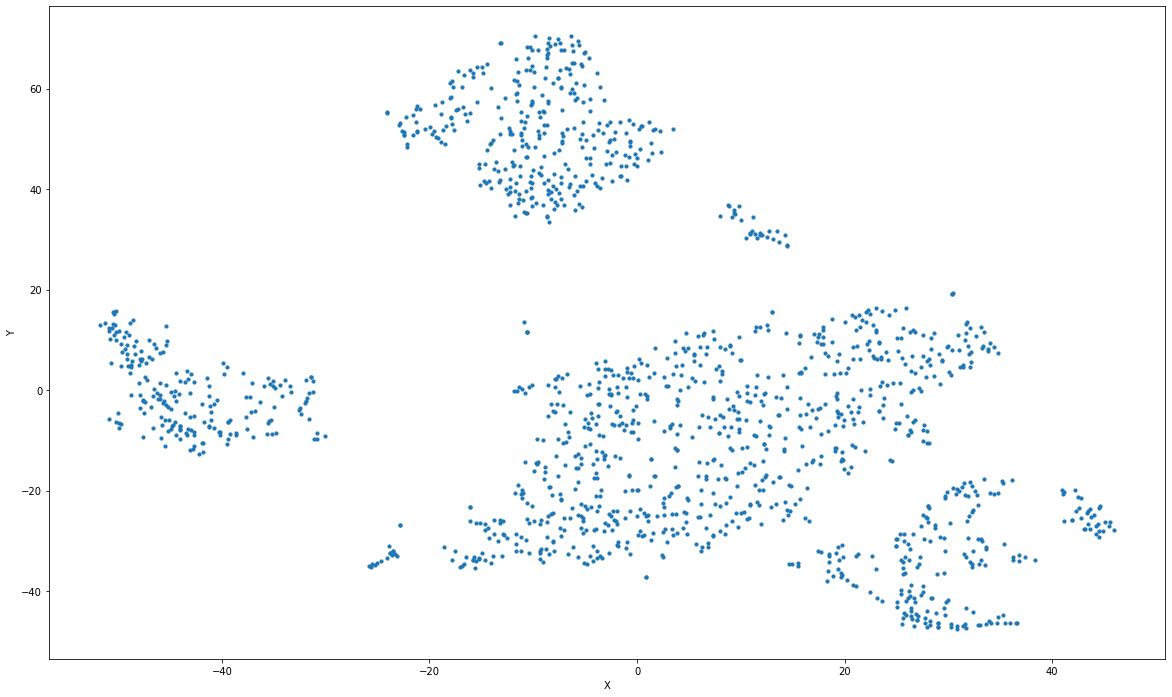

In [80]:
dataframe = pd.DataFrame( # Create a dataframe with the coordinates of the words
  [
    (word, coords[0], coords[1])
    for word, coords in [
      (word, matrix_dicc2d[kwords[word]])
      for word in kwords
    ]
  ],
  columns=["Word", "X", "Y"]
)

dataframe.plot.scatter("X", "Y", s=10, figsize=(20, 12)) # Plot the words
plt.show() # Show the plot

Ahora podemos crear diferentes clusters para testear lo que hicimos :)

Y jugar creando distintos clusters de palabras, de distinto tamaño y ver que obtenemos.

In [81]:
cluster_1 = clustering(25, red_matrix) # Create the clusters
cluster_2 = clustering(35, red_matrix) # Create the clusters
cluster_3 = clustering(45, red_matrix) # Create the clusters

In [82]:
print(getWordsInCluster(cluster_1, "ley"))

['pareja', 'hija', 'movimiento', 'problema', 'muerte', 'proyecto', 'aspecto', 'plazo', 'experiencia', 'interés', 'recurso', 'conflicto', 'ingreso', 'medida', 'reclamo', 'mejora', 'ley', 'plan', 'instancia', 'debate', 'posibilidad', 'unidad', 'entrada', 'relación', 'discusión', 'canal', 'cuestión', 'participación', 'argumento', 'diálogo', 'posición', 'base', 'información', 'planta', 'respuesta', 'espacio', 'cantidad', 'presencia', 'sistema', 'declaración', 'visita', 'camino', 'aporte', 'número', 'derecho', 'reunión', 'consecuencia', 'intervención', 'expediente', 'sanción', 'instalación', 'actividad', 'corte', 'asamblea', 'estrategia', 'capacidad', 'sospecha', 'dificultad', 'decisión', 'prueba', 'cuerpo', 'idea', 'dinero', 'rol', 'valor', 'palabra', 'negociación', 'modelo', 'precio', 'esfuerzo', 'decreto', 'presentación', 'denuncia', 'pago', 'tasa', 'demanda', 'crecimiento', 'costo', 'línea', 'proceso', 'puesto', 'delito', 'salida', 'opinión', 'paso', 'conducta', 'expectativa', 'polémica

In [90]:
print(getWordsInCluster(cluster_1, "lunes"))

['sentido', 'forma', 'sábado', 'miércoles', 'septiembre', 'martes', 'obstante', 'noche', 'momento', 'torno', 'plaza', 'diciembre', 'zona', 'manos', 'discurso', 'mano', 'viernes', 'octubre', 'lunes', 'minuto', 'fin', 'calle', 'jueves', 'período', 'semana', 'marzo', 'julio', 'sede', 'marco', 'mediados', 'contexto', 'verano', 'modos', 'humanos', 'vuelta', 'pese', 'domingo', 'superficie', 'hospital', 'mayo', 'madrugada', 'edición', 'vereda', 'mediodía', 'inicio', 'altura', 'hora', 'ámbito', 'ocasión', 'febrero', 'página', 'fines']


In [92]:
print(getWordsInCluster(cluster_2, "hermano"))

['comunicación', 'Jerónimo', 'infraestructura', 'calidad', 'docente', 'error', 'responsable', 'amigo', 'Alta', 'inclusión', 'profesional', 'capacitación', 'abril', 'Francia', 'padre', 'Instituto', 'Marina', 'Garzón', 'República', 'desarrollo', 'respeto', 'compromiso', 'reflexión', 'Servicios', 'organización', 'universidad', 'intendentes', 'transparencia', 'pobreza', 'caja', 'distribución', 'ausencia', 'localidad', 'suma', 'sur', 'teléfono', 'escritor', 'profesor', 'candidata', 'luz', 'cierre', 'Europa', 'contenido', 'título', 'hermano', 'conocimiento', 'protección', 'herido', 'complejo', 'material', 'amenaza', 'robo', 'justicia', 'horario', 'Venezuela', 'Colombia', 'Perú', 'izquierda', 'fracaso', 'dirección', 'droga', 'Uruguay', 'concejal', 'maíz', 'Ciudad', 'Abbas']


In [97]:
print(getWordsInCluster(cluster_2, "impuesto"))

['movimiento', 'recurso', 'instancia', 'educación', 'principio', 'hogar', 'empleado', 'defensa', 'seguridad', 'canal', 'nivel', 'acción', 'construcción', 'ciudadanía', 'necesidad', 'consenso', 'visión', 'interior', 'reconocimiento', 'gestión', 'inversión', 'acceso', 'energía', 'propiedad', 'comercio', 'grado', 'producción', 'consulta', 'presupuesto', 'marcha', 'rechazo', 'movilización', 'libro', 'formación', 'violencia', 'carne', 'viaje', 'destino', 'cabeza', 'caída', 'venta', 'alimento', 'cámara', 'servicio', 'control', 'opción', 'falta', 'impuesto', 'democracia', 'función', 'tecnología', 'política', 'generación', 'opinión', 'mensaje', 'partido', 'conducta', 'equipo', 'actitud', 'asignación', 'orden', 'apoyo', 'vivienda', 'régimen', 'arma', 'responsabilidad', 'expresión', 'decena', 'par', 'pie', 'auto', 'muerto', 'comunidad', 'asesinato', 'río', 'cultura', 'semáforo', 'esquina', 'tramo', 'transporte', 'atentado', 'asistencia', 'dictadura', 'bandera', 'creación', 'gas', 'ayuda', 'gasto

In [85]:
print(getWordsInCluster(cluster_3, "colegio"))

['colegio', 'reforma', 'ley', 'centro', 'agua', 'edificio', 'tierra', 'ruta', 'país', 'campo', 'población', 'radicalismo', 'mundo', 'crédito', 'parte', 'salario', 'línea', 'disputa', 'delito', 'voto', 'ganador', 'descuento', 'subsidio', 'fondo', 'cama', 'vehículo', 'prisión', 'éxito', 'rescate', 'confianza', 'origen', 'ciencia', 'guerra', 'contrato', 'urna', 'boleta', 'órgano', 'cartera', 'ejercicio', 'nación', 'comicio', 'vuelo', 'entrega', 'basura', 'medicina', 'concurso', 'trasplante', 'donante']


In [86]:
print(getWordsInCluster(cluster_3, "Argentina"))

['Dios', 'Ministerio', 'Consejo', 'Argentina', 'Justicia', 'Secretaría', 'Marcos', 'Legislatura', 'Comisión', 'Corte', 'Internet', 'Frente', 'PJ', 'CTA', 'Asociación', 'Epec', 'UCR', 'Curitiba', 'Plan', 'Policía', 'Hospital', 'Fiat', 'Senado', 'Tribunal', 'Washington', 'Tamse']
